# MNIST Neural Network From Scratch

The goal of this short project is to train a neural network, using the MNIST dataset, using only linear algebra via Numpy. The MNIST dataset is a collection of 28x28 handwritten digits with corresponding integer values for the represented digit. The model as currently constructed can correctly identify about 90% of hand drawn digits. Using actual data science modules, accuracy well over 98% can be achieved. The data for this project can be accessed __[Here](http://yann.lecun.com/exdb/mnist/)__.

In [1]:
#Import Modules
import numpy as np
#numpy for all data proccessing and modeling
from matplotlib import pyplot as plt
#Pyplot for image generation
from keras.datasets import mnist
#Mnist for loading dataset

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [2]:
#Load and Reshape data to have 60000 columns of 784 nodes
(train_X, train_y), (test_X, test_y) = mnist.load_data()
#Collapse 28x28 images into 784 node columns
train_X = np.reshape(train_X, (60000, 784))
test_X = np.reshape(test_X, (10000, 784))
m, n = train_X.shape
train_X = train_X.T
test_X = test_X.T

11490434/11490434 [==============================] - 1s 0us/step


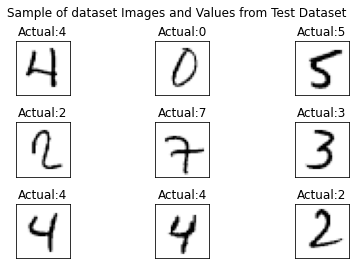

In [173]:
#Generate random samples for analysis
nums = np.random.randint(0, 9999, 9)
plt.figure(1)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[:,nums[i]].reshape(28,28), cmap='Greys')
    plt.yticks([])
    plt.xticks([])
    plt.title('Actual:' + str(test_y[nums[i]]))
plt.suptitle('Sample of dataset Images and Values from Test Dataset', y=1)
plt.subplots_adjust(hspace = .5, wspace = 1.5)

This project uses the sigmoid function as the activator and uses the softmax fuction to generate probabilities and thus predicitons. While there are functions that perform better in training than the sigmoid function, it was selected here for its ability to limit values and prevent them from exceeding the limits of float64.

##### Sigmoid Function:

$$
 A =  \frac{\mathrm{1} }{\mathrm{1} + e^{-P} }  
$$

##### Softmax Function:

$$
A = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
$$

In [143]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def sigmoid_deriv(Z):
    dsig = (np.exp(-Z))/((np.exp(-Z)+1)**2)
    #Some extremely large numbers are passed through here that give infinetesimal values. To account for problems caused by this these values are set to 0.
    dsig = np.nan_to_num(dsig)
    return dsig

def y_col_arr(Y):
    #Set y values to be arrays of length 10 where the solution is 1 and all other values are 0
    y_col_array = np.zeros((Y.size, Y.max() + 1))
    y_col_array[np.arange(Y.size), Y] = 1
    y_col_array = y_col_array.T
    return y_col_array

def get_predictions(A3, Y):
    #Find predicted values from probability vectors
    predictions = np.argmax(A3,0)
    print('Predictions:')
    print(predictions)
    print('Solutions:')
    print(Y)
    #Generate accuracy value
    accuracy = np.sum(predictions == Y)/ Y.size
    return accuracy, predictions

In [133]:
def init_params():
    #Generate initial constants as random values between -.5 and .5
    W1 = np.random.rand(72, 784) - 0.5
    b1 = np.random.rand(72, 1) - 0.5
    W2 = np.random.rand(36, 72) - 0.5
    b2 = np.random.rand(36, 1) - 0.5
    W3 = np.random.rand(10, 36) - 0.5
    b3 = np.random.rand(10, 1,) - 0.5
    return (W1, b1, W2, b2, W3, b3)

This neural network utilizes two hidden layers with 72 and 36 nodes respectively. This combination gives a good amount of accuracy without requiring too much time to run.

##### Forward Propogation:

$$
Z^{[1]} = W^{[1]} X + b^{[1]}
$$
$$
A^{[1]} = g_{\text{sigmoid}}(Z^{[1]}))
$$

$$
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}
$$
$$
A^{[2]} = g_{\text{sigmoid}}(Z^{[2]}))
$$

$$
Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}
$$
$$
A^{[3]} = g_{\text{softmax}}(Z^{[3]})
$$

##### Backward Propogation:
$$
dZ^{[3]} = A^{[3]} - Y
$$
$$
dW^{[3]} = \frac{1}{m} dZ^{[3]} A^{[2]T}
$$
$$
dB^{[3]} = \frac{1}{m} \Sigma {dZ^{[3]}}
$$

$$
dZ^{[2]} = W^{[3]T} dZ^{[3]} .* g^{[2]\prime} (z^{[2]})
$$
$$
dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}
$$
$$
dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}
$$

$$
dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})
$$
$$
dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}
$$
$$
dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}
$$

##### Update Parameters:
$$
W^{[3]} = W^{[3]} - \alpha dW^{[3]}
$$
$$
b^{[3]} = b^{[3]} - \alpha db^{[3]}
$$

$$
W^{[2]} = W^{[2]} - \alpha dW^{[2]}
$$
$$
b^{[2]} = b^{[2]} - \alpha db^{[2]}
$$

$$
W^{[1]} = W^{[1]} - \alpha dW^{[1]}
$$
$$
b^{[1]} = b^{[1]} - \alpha db^{[1]}
$$

This iterates 500 times to appropriately train the model.

In [134]:
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    #Compute node values from X data and constant values
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    return (Z1, A1, Z2, A2, P3, A3)

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    #Find gradient of cost function to determine the dW and db values that are used to adjust constants
    y_col_arr_Y = y_col_arr(Y)
    dZ3 = A3 - y_col_arr_Y
    dW3 = 1/m * dZ3.dot(A2.T)
    db3 = 1/m * np.sum(dZ3)
    dZ2 = W3.T.dot(dZ3) * sigmoid_deriv(Z2)
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * sigmoid_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)  
    return (dW1, db1, dW2, db2, dW3, db3)

def update_par(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    #Adjust constants based db dW and alpha
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return (W1, b1, W2, b2, W3, b3)

In [181]:
import warnings
    
def gradient_decent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    #Iterate through forward prop - backward prop - update par 500 times 
    for i in range(iterations):
        warnings.filterwarnings('ignore')
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_par(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 25 == 0:
            #Report status of model for every fifth iteration.
            print('Iterations: ', i)
            accuracy, predictions = get_predictions(A3, Y)
            print(str(accuracy*100) + '%')
    print('Final Accuracy')
    accuracy, predictions = get_predictions(A3,Y)
    print(str(accuracy*100) + '%')
            

    return (W1, b1, W2, b2, W3, b3)

In [182]:
#Train Model
W1, b1, W2, b2, W3, b3 = gradient_decent(train_X, train_y, 1, 500)

Iterations:  0
Predictions:
[6 6 6 ... 6 4 6]
Solutions:
[5 0 4 ... 5 6 8]
10.638333333333334%
Iterations:  25
Predictions:
[3 0 4 ... 3 0 1]
Solutions:
[5 0 4 ... 5 6 8]
66.795%
Iterations:  50
Predictions:
[5 0 4 ... 5 0 5]
Solutions:
[5 0 4 ... 5 6 8]
78.38166666666667%
Iterations:  75
Predictions:
[5 0 4 ... 5 0 9]
Solutions:
[5 0 4 ... 5 6 8]
82.87833333333333%
Iterations:  100
Predictions:
[5 0 4 ... 5 0 8]
Solutions:
[5 0 4 ... 5 6 8]
85.26166666666667%
Iterations:  125
Predictions:
[5 0 4 ... 5 0 8]
Solutions:
[5 0 4 ... 5 6 8]
86.74833333333333%
Iterations:  150
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
87.84333333333333%
Iterations:  175
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
88.66166666666668%
Iterations:  200
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
89.20666666666666%
Iterations:  225
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
89.80333333333334%
Iterations:  250
Predictions:
[5 0 4 ... 5 6 8]
Solutio

92.9% accuracy on training data.

In [183]:
#Test Model
Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, test_X)
accuracy, predictions = get_predictions(A3, test_y)
print(str(accuracy*100) + '%')

Predictions:
[7 2 1 ... 4 5 6]
Solutions:
[7 2 1 ... 4 5 6]
91.11%


91.1% accuracy on test data.

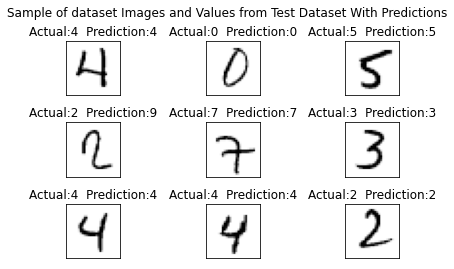

In [184]:
plt.figure(1)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[:,nums[i]].reshape(28,28), cmap='Greys')
    plt.yticks([])
    plt.xticks([])
    plt.title('Actual:' + str(test_y[nums[i]]) + '  Prediction:' + str(predictions[nums[i]]))
plt.suptitle("Sample of dataset Images and Values from Test Dataset With Predictions", y=1)
plt.subplots_adjust(hspace = .5, wspace = 1.5)

Here you can see examples of the numbers that the model correctly identifies and one example of a 2 which it guesses is a 9. 

By using only numpy, linear algebra, and multivariable calculus this neural network is able to estimate digits from hand drawn images 91.1% of the time. With more tinkering or more training data its possible this neural network could be more accurate, but considering its limited resources 91.1% is a respectable success rate.

## But what about convolution?

Convolutional layers are often used in computer vision tasks because they can drastically improve the performance of a neural network. Below we will apply a single convolutional layer to try and increase the accuracy of our model.

Steps:
    convolution forward pass
    max pool forward pass
    flatten forward pass

    convolution back prop
    max pool back prop
    flatten back prop
    new loop

In [4]:
print(np.shape(train_X))

(60000, 28, 28)


In [27]:
nin = 28
padding = 0
kernel_size = 3
stride = 1
nout = ((nin + padding - kernel_size)/stride) + 1
print(nout)


26.0


In [38]:
print(initial_filter)

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]


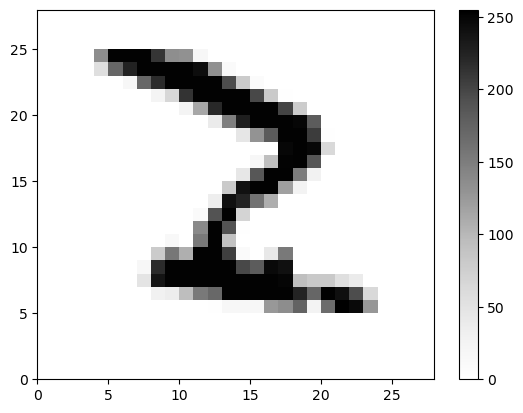

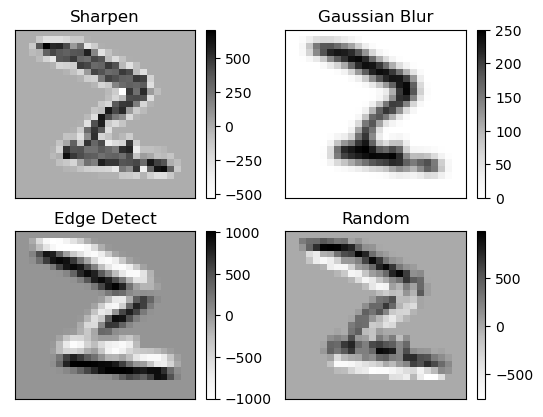

In [52]:
test_image = train_X[0,:,:]
plt.figure(1)
plt.pcolormesh(test_image, cmap='Greys')
plt.colorbar()
#initial_filter = np.ones((3,3))
#initial_filter[:,:] = .5
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
gaussian_blur = (1/16)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
edge_detection = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
random_filter = np.random.randint(-3, 3, (3, 3))
sharpened_image = np.zeros((26, 26))
blured_image = np.zeros((26, 26))
edge_detected_image = np.zeros((26, 26))
random_filtered_image = np.zeros((26, 26))

for i in range(26):
    for j in range(26):
        im_sect = test_image[i:i+3, j:j+3]
        #print(i, j)
        sharpened_image[i, j] = np.sum(im_sect * sharpen)
        blured_image[i, j] = np.sum(im_sect * gaussian_blur)
        edge_detected_image[i, j] = np.sum(im_sect * edge_detection)
        random_filtered_image[i, j] = np.sum(im_sect * random_filter)

plt.figure(2)
plt.subplot(221)
plt.pcolormesh(sharpened_image, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.title('Sharpen')
plt.colorbar()
plt.subplot(222)
plt.pcolormesh(blured_image, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.title('Gaussian Blur')
plt.colorbar()
plt.subplot(223)
plt.pcolormesh(edge_detected_image, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.title('Edge Detect')
plt.colorbar()
plt.subplot(224)
plt.pcolormesh(random_filtered_image, cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.title('Random')
plt.colorbar()


In [11]:
32*32

1024